In [155]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image

import numpy as np
import pandas as pd
import gym


from tf_agents.environments import suite_gym
import tensorflow as tf
from tensorflow import keras


In [156]:
tf.version.VERSION

'2.14.0'

In [157]:
rng = np.random.default_rng(seed=42)

# Exploring an environment

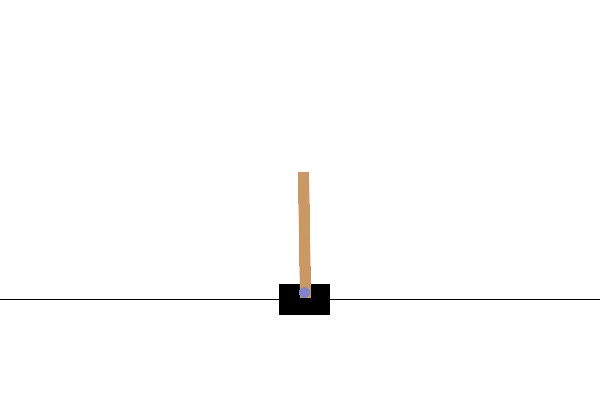

In [5]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

In [6]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Reward Spec:')
print(env.time_step_spec().reward)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [7]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.0247175 ,  0.02047254, -0.04262043, -0.01569063], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.02512696,  0.21617898, -0.04293424, -0.32151031], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


In [17]:
env.wrapped_env

In [8]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [9]:
from tf_agents.environments import tf_py_environment
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Gym

In [5]:
env = gym.make('CartPole-v1')
obs = env.reset()
obs

array([0.04074907, 0.00035212, 0.00786927, 0.02454426], dtype=float32)

In [5]:
gym.envs.registry.all()

ValuesView(├──CartPole: [ v0, v1 ]
├──MountainCar: [ v0 ]
├──MountainCarContinuous: [ v0 ]
├──Pendulum: [ v1 ]
├──Acrobot: [ v1 ]
├──LunarLander: [ v2 ]
├──LunarLanderContinuous: [ v2 ]
├──BipedalWalker: [ v3 ]
├──BipedalWalkerHardcore: [ v3 ]
├──CarRacing: [ v1 ]
├──Blackjack: [ v1 ]
├──FrozenLake: [ v1 ]
├──FrozenLake8x8: [ v1 ]
├──CliffWalking: [ v0 ]
├──Taxi: [ v3 ]
├──Reacher: [ v2 ]
├──Pusher: [ v2 ]
├──InvertedPendulum: [ v2 ]
├──InvertedDoublePendulum: [ v2 ]
├──HalfCheetah: [ v2, v3 ]
├──Hopper: [ v2, v3 ]
├──Swimmer: [ v2, v3 ]
├──Walker2d: [ v2, v3 ]
├──Ant: [ v2, v3 ]
├──Humanoid: [ v2, v3 ]
└──HumanoidStandup: [ v2 ]
)

In [7]:
img = env.render(mode='rgb_array')
img.shape

(400, 600, 3)

In [8]:
env.action_space

Discrete(2)

In [10]:
action = 1
obs, reward, done, info = env.step(action)
print(f'''
Obs: {obs}
Reward: {reward}
Done: {done}
Info: {info}
''')


Obs: [-0.01811634  0.38695762 -0.03350899 -0.58648235]
Reward: 1.0
Done: False
Info: {}



# Defining a basic policy

In [11]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for sim in range(500):
    sim_reward = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, _ = env.step(action)
        sim_reward += reward
        if done:
            break

    totals += [sim_reward]

In [14]:
pd.DataFrame(totals).describe()

,0
count,500.000000
mean,42.168000
std,9.264093
min,24.000000
25%,36.000000
50%,41.000000
75%,49.000000
max,72.000000


# A neural network policy

In [235]:
n_inputs = 4 # because there are 4 components to a state
model = keras.models.Sequential([
    keras.layers.Dense(5, activation='elu', input_shape=[n_inputs]),
    keras.layers.Dense(1, activation='sigmoid')
])

# Policy gradient

In [236]:
obs = env.reset()
left_proba = model(obs[np.newaxis])

In [240]:
tf.constant([[1.]]) - tf.cast(tf.random.uniform([1,1])>left_proba, tf.float32)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [36]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1,1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables) #gradient of mean of loss function at the value of trainable variables in model
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [50]:
# get simulations
def play_multiple_sims(env, n_sims, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for sim in range(n_sims):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards += [reward]
            current_grads += [grads]
            if done:
                break
        all_rewards += [current_rewards]
        all_grads += [current_grads]
    return all_rewards, all_grads

# calculate rewards
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards)-2, -1, -1):
        discounted[step] += discounted[step+1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) for 
                              rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std
            for discounted_rewards in all_discounted_rewards]

In [58]:
n_iterations = 150 # repeated training where you optimize gradients in each step
n_sims = 10
n_max_steps = 200
discount_factor = 0.95

optimizer = keras.optimizers.legacy.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [59]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_sims(env, n_sims, n_max_steps, model, loss_fn)
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[sim][step][var_index]
             for sim, final_rewards in enumerate(all_final_rewards)
             for step, final_reward in enumerate(final_rewards)], axis=0
        )
        all_mean_grads += [mean_grads]
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

In [60]:
model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(4, 5) dtype=float32, numpy=
 array([[-0.1374816 ,  0.39937097, -0.65255404, -1.4295857 , -1.4220834 ],
        [-0.01445661, -0.06559996,  0.64090896, -0.78423   , -0.76547426],
        [ 1.2849865 , -0.9671943 ,  0.3151514 ,  1.1197832 ,  1.0618933 ],
        [ 0.5079479 ,  0.12905097,  0.4829086 ,  0.8265821 ,  0.25307614]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(5,) dtype=float32, numpy=
 array([-0.5826873 ,  0.76378417, -0.8862204 , -0.6925781 , -0.6612593 ],
       dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(5, 1) dtype=float32, numpy=
 array([[-1.6968739],
        [ 1.3353534],
        [-1.0805607],
        [-0.7011231],
        [-1.002404 ]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([0.64891714], dtype=float32)>]

# Markov Decision Process
Bellman's optimality. Applied to example in textbook.

In [154]:
# Env setup
transition_probabilities = [
    [[0.7, 0.3, 0.], [1., 0., 0.], [0.8, 0.2, 0.]], # sOrigin, aX, sDest
    [[0., 1., 0.], None, [0., 0., 1.]],
    [None, [0.8, 0.1, 0.1], None]
]

rewards = [
    [[10., 0., 0.], [0., 0., 0.], [0., 0., 0.,]],
    [[0., 0., 0.], [0., 0., 0.], [0., 0., -50.]],
    [[0., 0., 0.], [40., 0., 0.], [0., 0., 0.]]
]

possible_actions = [[0, 1, 2], [0, 2], [1]] # possible actions in each state
n_states = len(rewards)
n_actions = len(rewards[0])

gamma = 0.9 # discount factor (try playing around with this to see impact on Q-values)

In [155]:
Q_values = np.full((n_states,n_actions), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0

for i in range(50):
    Q_prev = Q_values.copy()
    for s in range(n_states): # number of origin states
        for a in possible_actions[s]:
            Q_values[s][a] = np.sum([
                transition_probabilities[s][a][sn] * (rewards[s][a][sn] + gamma * np.max(Q_prev[sn]))
                for sn in range(n_states) # number of destination states
            ])

Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

# Q-learning
Environment unknown to agent

In [150]:
def step(state, action): # simulating a step
    probas = transition_probabilities[state][action]
    sn = rng.choice(range(n_states), p=probas)
    reward = rewards[state][action][sn]
    return sn, reward

def exploration_policy(state): # how agent explores
    return rng.choice(possible_actions[state])

In [151]:
alpha0 = 0.05 # initial environment learning rate
decay = 0.005 # environment learning rate decay
gamma = 0.9 # reward discount factor

In [166]:
state = 0 # start here
Q_values = np.full((n_states,n_actions), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0


for iteration in range(10000):
    action = exploration_policy(state)
    sn, reward = step(state, action)
    best_future_value = np.max(Q_values[sn])
    
    #adjust learning rate
    alpha = alpha0 / (1+iteration*decay)

    Q_values[state, action] *= 1 - alpha # partially keep the same
    Q_values[state, action] += alpha * (reward + gamma * best_future_value) # partially learn
    state = sn
Q_values

array([[18.08340549, 15.92960031, 12.76444801],
       [ 0.        ,        -inf, -8.66321115],
       [       -inf, 48.11379325,        -inf]])

# Deep Q-learning
With (decaying) epsilon-greedy exploration

In [207]:
env = gym.make("CartPole-v0")
input_shape = list(env.observation_space.shape)
n_outputs = env.action_space.n

In [208]:
model = keras.models.Sequential([
    keras.layers.Dense(32, activation='elu', input_shape=input_shape),
    keras.layers.Dense(32, activation='elu'),
    keras.layers.Dense(n_outputs)
])

target_model = keras.models.clone_model(model)
target_model.set_weights(model.get_weights())

In [209]:
# define a replay buffer
from collections import deque
replay_buffer = deque(maxlen=2000)
temp_a = []

In [210]:
def epsilon_greedy_policy(state, epsilon=0):
    if rng.random() < epsilon:
        return rng.integers(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)
        return np.argmax(Q_values[0])

In [211]:
def sample_experience(batch_size):
    indices = rng.integers(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, states_next, dones = [np.array([experience[f] for experience in batch])
                                                    for f in range(5)] # 5 fields in an experience: state, action, reward, next_state, done
    return states, actions, rewards, states_next, dones

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    state_next, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, state_next, done))
    return state_next, reward, done

In training, we get the target Q_value by using observed reward for action actually taken plus (discounted) model predicted, optimal future reward from the next state. The predicted Q_value for action is just the model prediction for the action actually taken.

In [212]:
def training_step(batch_size):
    experiences = sample_experience(batch_size)
    states, actions, rewards, states_next, dones = experiences
    next_Q_values_per_sa = model.predict(states_next, verbose=0)
    max_next_Q_values_per_s = np.max(next_Q_values_per_sa, axis=1) # optimal action in next state given model
    target_Q_values_per_s = (rewards + (1-dones)*discount_factor*max_next_Q_values_per_s) # reward considering optimal action in next state (and thus, recursively, in all future states)
    mask = tf.one_hot(actions, n_outputs) # mask to keep only outputs corresponding to action actually taken

    with tf.GradientTape() as tape:
        all_Q_values = model(states) # predict Q_values at current state
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True) # keep only those for action actually taken
        loss = tf.reduce_mean(loss_fn(target_Q_values_per_s, Q_values)) # calculate mean loss
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

def training_step_with_target_model(batch_size):
    experiences = sample_experience(batch_size)
    states, actions, rewards, states_next, dones = experiences
    next_Q_values_per_sa = target_model.predict(states_next, verbose=0)
    max_next_Q_values_per_s = np.max(next_Q_values_per_sa, axis=1) # optimal action in next state given model
    target_Q_values_per_s = (rewards + (1-dones)*discount_factor*max_next_Q_values_per_s) # reward considering optimal action in next state (and thus, recursively, in all future states)
    mask = tf.one_hot(actions, n_outputs) # mask to keep only outputs corresponding to action actually taken

    with tf.GradientTape() as tape:
        all_Q_values = model(states) # predict Q_values at current state
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True) # keep only those for action actually taken
        loss = tf.reduce_mean(loss_fn(target_Q_values_per_s, Q_values)) # calculate mean loss
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
        

In [213]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.legacy.Adam(learning_rate=0.001)
loss_fn = keras.losses.mean_squared_error

In [183]:
n_sims = 600
n_max_steps = 200
training_start_len = 50
total_rewards = []

for sim in range(n_sims):
    print(sim)
    obs = env.reset()
    for step in range(n_max_steps):
        epsilon = max(1-sim/500, 0.01)
        obs, reward, done = play_one_step(env, obs, epsilon)
        if done:
            break
    total_rewards += [step]
    if sim > training_start_len:
        training_step(batch_size)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

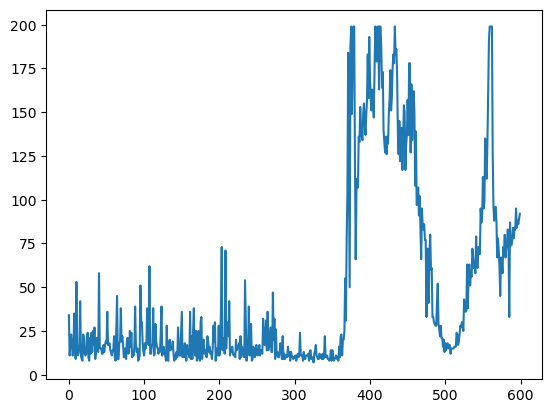

In [184]:
plt.plot(range(n_sims), total_rewards)
plt.show()

In [214]:
n_sims = 600
n_max_steps = 200
training_start_len = 50
total_rewards = []

for sim in range(n_sims):
    print(sim)
    obs = env.reset()
    for step in range(n_max_steps):
        epsilon = max(1-sim/500, 0.01)
        obs, reward, done = play_one_step(env, obs, epsilon)
        if done:
            break
    total_rewards += [step]
    if sim > training_start_len:
        training_step_with_target_model(batch_size)
        if sim % 50 == 0:
            target_model.set_weights(model.get_weights())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

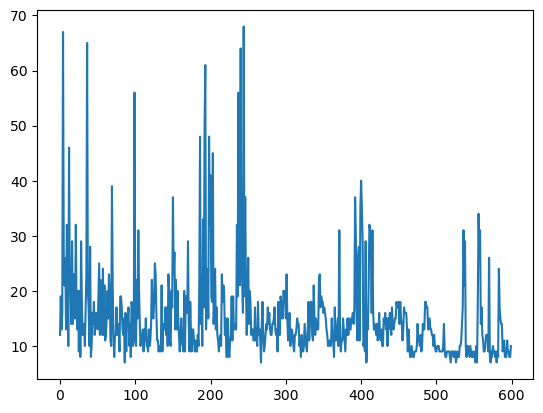

In [215]:
plt.plot(range(n_sims), total_rewards)
plt.show()